## **Profile Plotter Notebook**

The following notebook was used to create plots of memory and time of profiled data from `hasasia.sensitivity` `pulsar` and `spectrum` creation. The main focus was to give empirical evidence for the computational bottleneck for computing characteristic strain is the inverse noise-weighted transmission function, `NcalInv`.

Note that this program has assumed that you have previously executed `profile_test.py`. This is what we are gathering the profile data from.

In [18]:
import time, os, subprocess, random, h5py, glob, json
import matplotlib.pyplot as plt
import numpy  as np
import seaborn as sns

In [19]:
def yr_15_data():
    data_dir = os.path.expanduser('~/Research/Nanograv/NANOGrav15yr_PulsarTiming_v2.0.0/minish/jpg00017/NANOGrav15yr_PulsarTiming_v2.0.0/narrowband/')
    par_dir = data_dir + r'par/'
    tim_dir = data_dir + r'tim/'
    noise_file = data_dir+r'15yr_wn_dict.json'
    jeremy_psrs =["B1855+09","B1937+21","B1953+29","J0023+0923","J0030+0451","J0340+4130","J0406+3039","J0437-4715","J0509+0856",
                        "J0557+1551","J0605+3757","J0610-2100","J0613-0200","J0636+5128","J0645+5158","J0709+0458","J0740+6620",
                        "J0931-1902","J1012+5307","J1012-4235","J1022+1001","J1024-0719","J1125+7819","J1312+0051","J1453+1902",
                        "J1455-3330","J1600-3053","J1614-2230","J1630+3734","J1640+2224","J1643-1224","J1705-1903","J1713+0747",
                        "J1719-1438","J1730-2304","J1738+0333","J1741+1351","J1744-1134","J1745+1017","J1747-4036","J1751-2857",
                        "J1802-2124","J1811-2405","J1832-0836","J1843-1113","J1853+1303","J1903+0327","J1909-3744","J1910+1256",
                        "J1911+1347","J1918-0642","J1923+2515","J1944+0907","J1946+3417","J2010-1323","J2017+0603","J2033+1734",
                        "J2043+1711","J2124-3358","J2145-0750","J2214+3000","J2229+2643","J2234+0611","J2234+0944","J2302+4442",
                        "J2317+1439","J2322+2057"]

    #sorting parameter and timing files
    parfiles = sorted(glob.glob(par_dir+'*.par'))
    timfiles = sorted(glob.glob(tim_dir+'*.tim'))
   
    filter_parfiles = []
    for file in parfiles:
        if 'ao' in file:
            continue
        if 'gbt' in file:
            continue
        filter_parfiles.append(file)

    filter_timfiles = []
    for file in timfiles:
        if 'ao' in file:
            continue
        if 'gbt' in file:
            continue
        filter_timfiles.append(file)
    
    del parfiles, timfiles

    par_psr_names = []
    for file in filter_parfiles:
        par_psr_names.append(get_psrname(file))
    

    tim_psr_names = []
    for file in filter_timfiles:
        tim_psr_names.append(get_psrname(file))

    psr_list= [item for item in tim_psr_names if item in par_psr_names]
    
    exclude_psr = next(iter(set(psr_list) - set(jeremy_psrs)))
    
    pars =[]
    for file in filter_parfiles:
        if get_psrname(file) == exclude_psr:
            continue
        pars.append(file)

    tims = []
    for file in filter_timfiles:
        if get_psrname(file) == exclude_psr:
            continue
        tims.append(file)
    
    del filter_parfiles, filter_timfiles

    if len(pars) != 67 or len(tims) !=67:
        exit()

    noise = {}
    with open(noise_file, 'r') as fp:
        noise.update(json.load(fp))        
    
    rn_psrs = {}
    for name in psr_list:
        amp_key = name + '_red_noise_log10_A'
        gamma_key = name + '_red_noise_gamma'
        for key in noise:
            if key == amp_key or key == gamma_key:
                rn_psrs[name] = ['x','x']
    
    #place proper entries
    for name in jeremy_psrs:
        amp_key = name + '_red_noise_log10_A'
        gamma_key = name + '_red_noise_gamma'
        for key in noise:
            if key == amp_key:
                rn_psrs[name][0] = 10**noise[amp_key]  #because parameter is log_10()
            elif key == gamma_key:
                rn_psrs[name][1] = noise[gamma_key]

    edir = '/15_yr_enterprise_pulsars.hdf5'
    ephem = 'DE440'

    return pars, tims, noise, rn_psrs, edir, ephem


def get_psrname(file,name_sep='_'):
    """Function that grabs names of pulsars from parameter files
    
    Returns:
        Pulsar name
    """
    return file.split('/')[-1].split(name_sep)[0]

The following cell extracts memory vs time of the program.

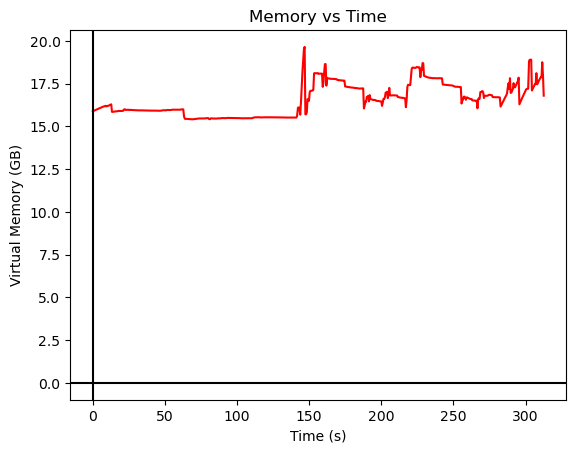

In [20]:
#path containing profile data
profile_path = os.path.expanduser('~/Profile_Data')
#specific path for log of time vs memory
log_path = profile_path+'/time_mem_data.txt'

mem_data = []
time_data = []
#opening folder and reading memory and time usage
with open(log_path, 'r') as file:  
    for line in file:
        line_sep = line.split(',')
        time_data.append(float(line_sep[0]))
        mem_data.append(float(line_sep[1]))

#converting time and memory data into numpy array in order to take offset
time_data = np.array(time_data)
null_time = time_data[0]
time_data = time_data-null_time
mem_data = np.array(mem_data)

#plot of memory us time
plt.title('Memory vs Time')
plt.plot(time_data, mem_data, c='red')
plt.xlabel('Time (s)')
plt.ylabel('Virtual Memory (GB)')
plt.axhline(c='black')
plt.axvline(c='black')
plt.savefig(profile_path+'/mem_time.svg')
plt.show()

Lets plot the memory it takes to create `sensitivity.pulsar` objects from the entire time vs memory program

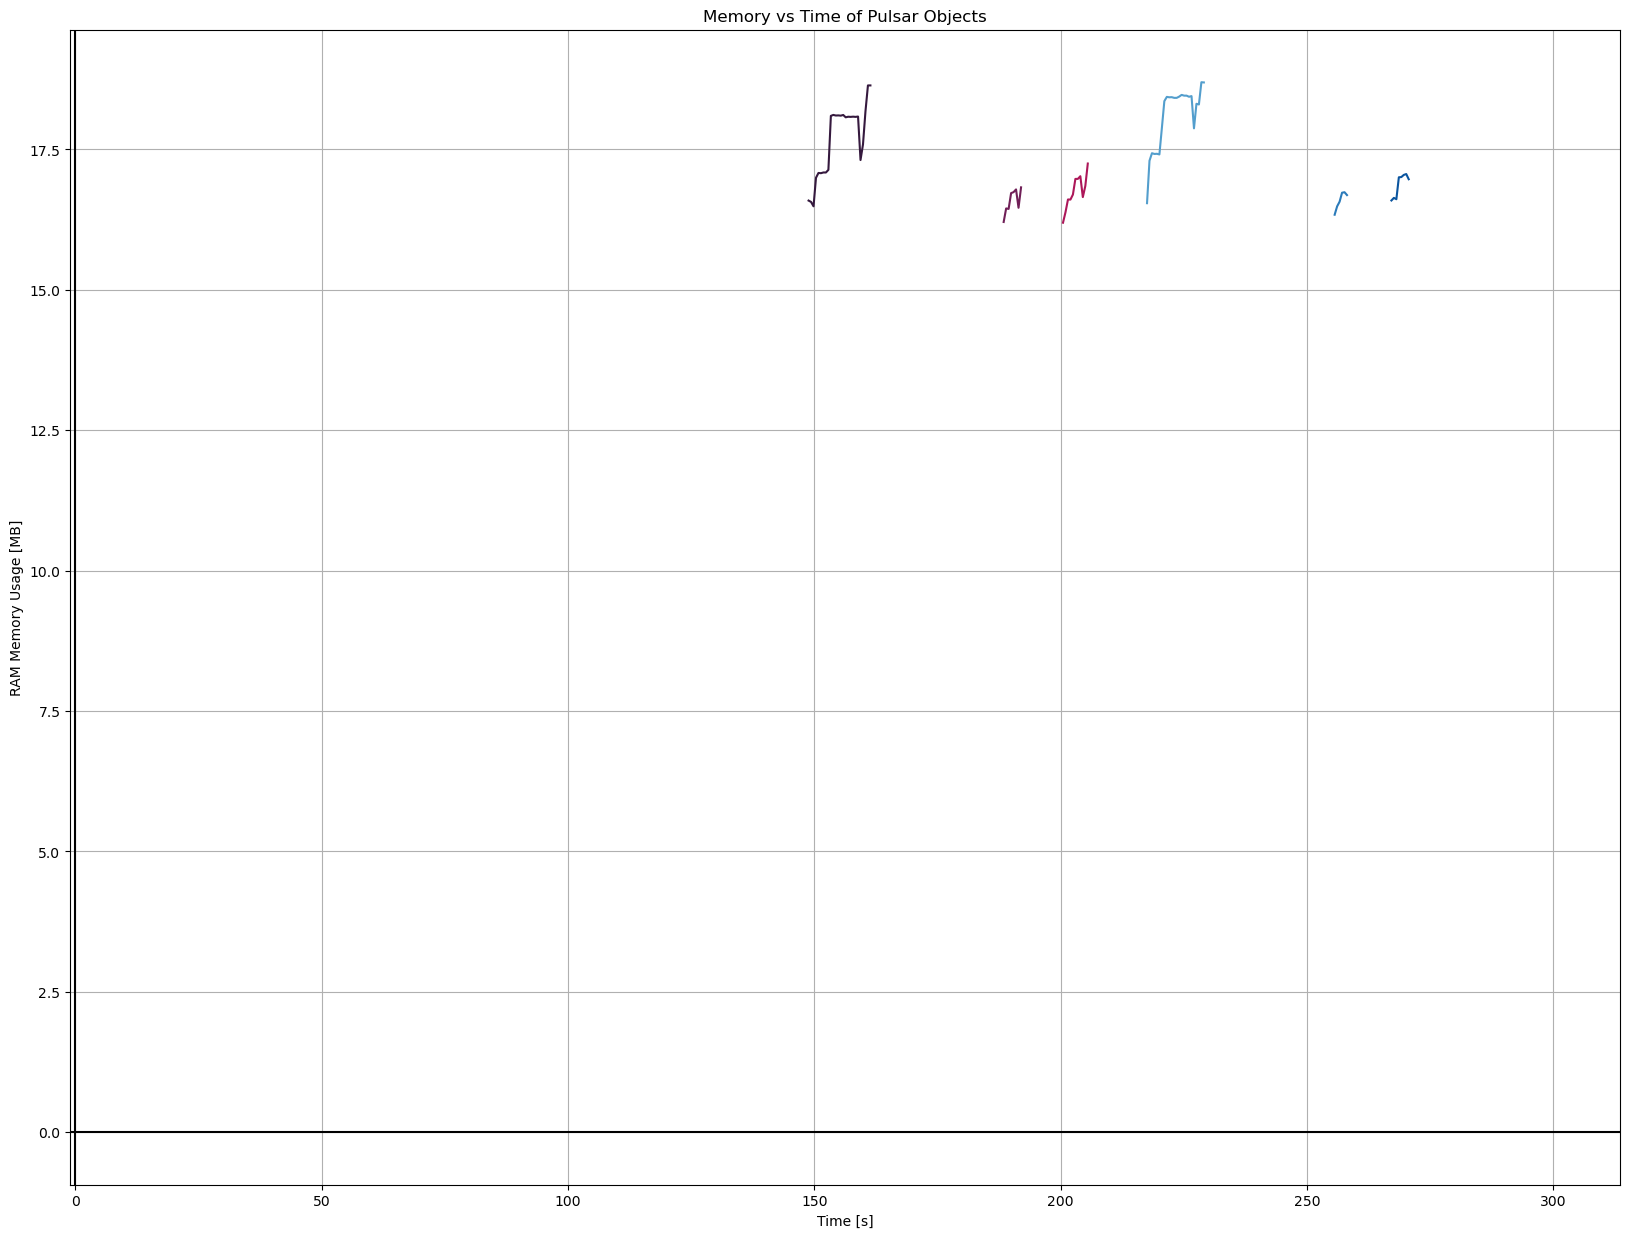

In [21]:
increms_psrs = []
#opening file containing all the time differences it took to create each pulsar object
with open(profile_path + '/psr_increm.txt', 'r') as file:
    for line in file:
        line = line.strip('\n').split()
        increms_psrs.append(line)

#color selected to plot each pulsar   Crimson
color_1 = sns.color_palette("Blues", len(increms_psrs))
color_2 = sns.color_palette("rocket", len(increms_psrs))


#lists to hold time values of each pulsar split into RRF and WK formalisms
rrf_handles_psr = []
original_handles_psr = []

# Plot pulsar data
plt.figure(figsize=(20, 15))
plt.title(f"Memory vs Time of Pulsar Objects")
plt.xlabel('Time [s]')
plt.ylabel('RAM Memory Usage [MB]')
plt.grid()
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.xlim(time_data[0] - 1, time_data[-1] + 1)



#for-loop to iterate through all lines in the text file
for i in range(len(increms_psrs)):
    name_psr = increms_psrs[i][0] + increms_psrs[i][1]
    val_1_psr = float(increms_psrs[i][2])
    val_2_psr = float(increms_psrs[i][3])
    #get indices for the time range
    index_psr = np.where((time_data >= val_1_psr) & (time_data <= val_2_psr))

    #create plot object to save so I can plot it all at once
    #line_psr, = plt.plot(time_data[index_psr], mem_data[index_psr], label=name_psr, c=color[i])

    #filtering between RRF and WK formalism data
    if "RRF" in name_psr:
        line_psr, = plt.plot(time_data[index_psr], mem_data[index_psr], label=name_psr, c=color_1[i])
        rrf_handles_psr.append(line_psr)
    else:
        line_psr, = plt.plot(time_data[index_psr], mem_data[index_psr], label=name_psr, c=color_2[i])
        original_handles_psr.append(line_psr)


#creating good legends to show 67*2 objects
first_legend_psr = plt.legend(handles=original_handles_psr, loc='upper left', bbox_to_anchor=(-0.16, 1.15))
second_legend_psr = plt.legend(handles=rrf_handles_psr, loc='upper right', bbox_to_anchor=(1.12, 1.15))

# Add the legends to the plot
plt.gca().add_artist(first_legend_psr)
plt.gca().add_artist(second_legend_psr)
# Save and show the plot
plt.savefig(profile_path+'/colored_mem_time_psrs.svg')
plt.show()

Lets plot the memory it takes to create `sensitivity.spectrum` objects from the time vs memory plot of entire program

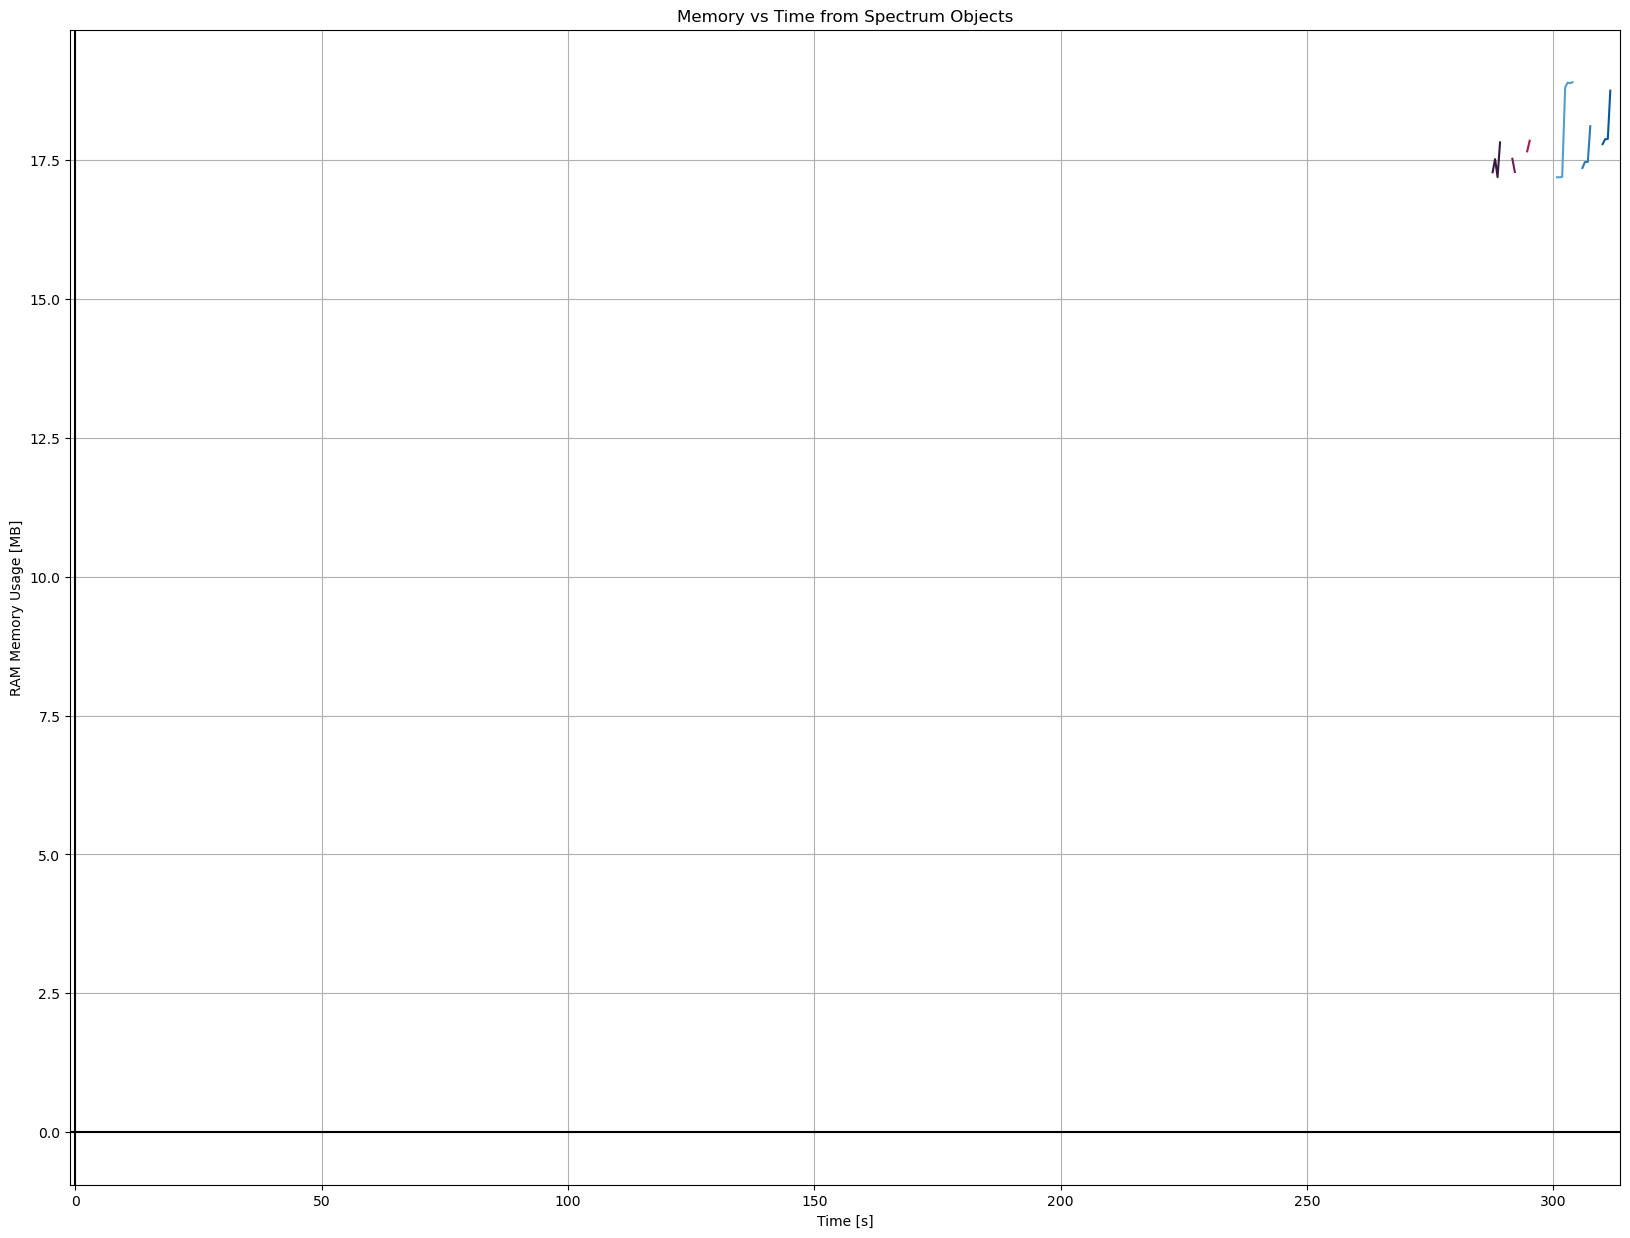

In [22]:
increms_specs = []
with open(profile_path + '/spec_increm.txt', 'r') as file:
    for line in file:
        line = line.strip('\n').split()
        increms_specs.append(line)

rrf_handles_specs = []
original_handles_specs = []

# Plot spectrum data
plt.figure(figsize=(20, 15))
plt.title(f"Memory vs Time from Spectrum Objects")
plt.xlabel('Time [s]')
plt.ylabel('RAM Memory Usage [MB]')
plt.grid()
plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')
plt.xlim(time_data[0] - 1, time_data[-1] + 1)

for i in range(len(increms_specs)): 
    name_psr = increms_specs[i][0] + increms_specs[i][1]
    val_1_spec = float(increms_specs[i][2])
    val_2_spec = float(increms_specs[i][3])

    index_specs = np.where((time_data >= val_1_spec) & (time_data <= val_2_spec))

    # Plot spectrum data
    if "RRF" in name_psr:
        line_specs, = plt.plot(time_data[index_specs], mem_data[index_specs], label=name_psr, color=color_1[i])
        rrf_handles_specs.append(line_specs)
    else:
        line_specs, = plt.plot(time_data[index_specs], mem_data[index_specs], label=name_psr, color=color_2[i])
        original_handles_specs.append(line_specs)

#creating good legends to show 67*2 objects
first_legend_psr = plt.legend(handles=original_handles_psr, loc='upper left', bbox_to_anchor=(-0.16, 1.15))
second_legend_psr = plt.legend(handles=rrf_handles_psr, loc='upper right', bbox_to_anchor=(1.12, 1.15))

# Add the legends to the plot
plt.gca().add_artist(first_legend_psr)
plt.gca().add_artist(second_legend_psr)

# Save and show the plot
#plt.xlim(6500,8500)
plt.savefig(profile_path+'/colored_mem_time_specs.svg')
plt.show()

Lets plot the time it takes to generate each `sensitivity.pulsar` object as a bar chart

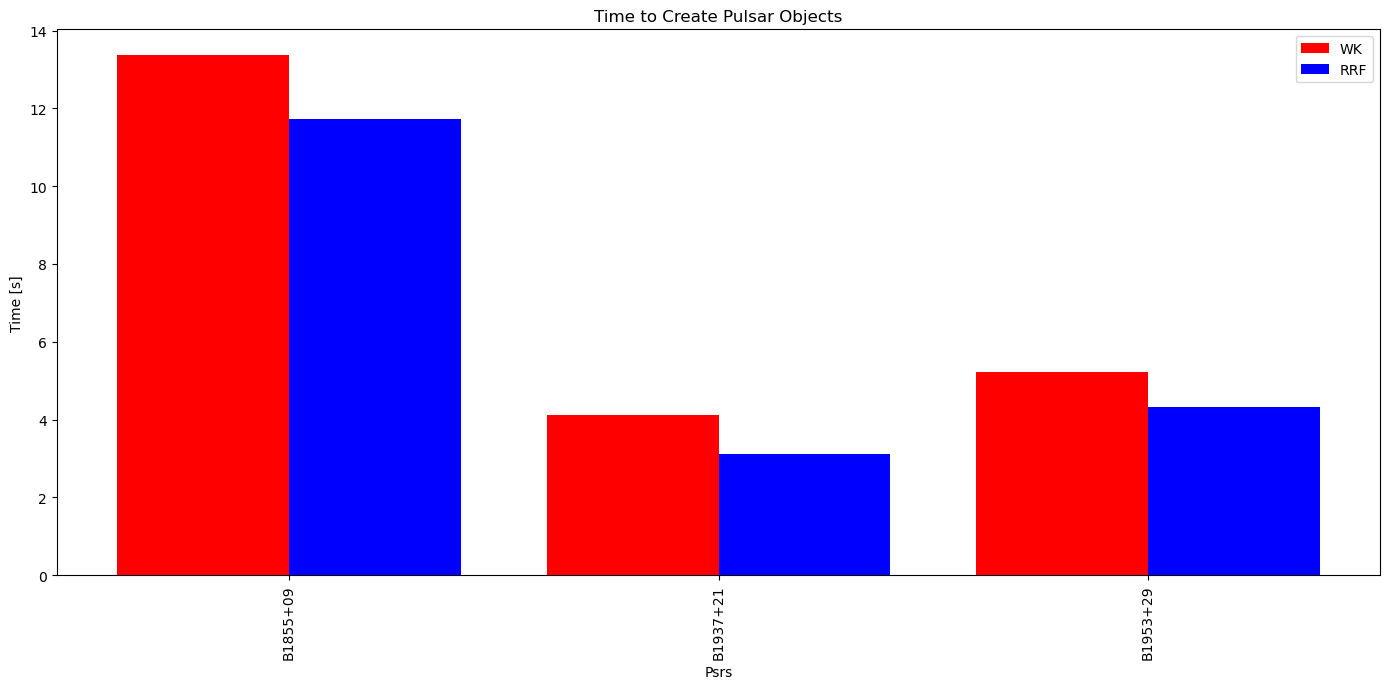

In [23]:
with open(profile_path + '/psr_increm.txt', 'r') as file:
    OGS_psrs = {}
    RRFS_psrs = {}
    for line in file:
        parse_line = line.split()
        if parse_line[0] == 'WK':
            OGS_psrs.update({parse_line[1]: (float(parse_line[3])-float(parse_line[2]))})

        elif parse_line[0] == 'RRF':
            RRFS_psrs.update({parse_line[1]: (float(parse_line[3])-float(parse_line[2]))})

    all_names = OGS_psrs.keys()
    ogs_plot_values_psrs = [OGS_psrs[name] if name in OGS_psrs else 0 for name in all_names]
    rrfs_plot_values_psrs = [RRFS_psrs[name] if name in RRFS_psrs else 0 for name in all_names]

    x = range(len(all_names))
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    plt.bar(x, ogs_plot_values_psrs, width=bar_width, label='WK', color='red', align='center')
    # Plot RRFS values (shifted to the right by bar_width)
    plt.bar([i + bar_width for i in x], rrfs_plot_values_psrs, width=bar_width, label='RRF', color='blue', align='center')
    # Add names to the x-axis
    plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)
    plt.xlabel('Psrs')
    plt.ylabel('Time [s]')
    plt.title('Time to Create Pulsar Objects')
    plt.legend(loc='upper right')
    # Show plot
    plt.tight_layout()
    plt.savefig(profile_path+'/time_bar_psrs.svg') 
    plt.show()


with open(profile_path+'/pulsar_total_time.txt', 'w') as file:
    file.write(f'Total WK Spec: {sum(ogs_plot_values_psrs)}\n')
    file.write(f'Total RRF Spec: {sum(rrfs_plot_values_psrs)}\n')

Lets plot the memory it takes to generate each `sensitivity.spectrum` object as a bar chart

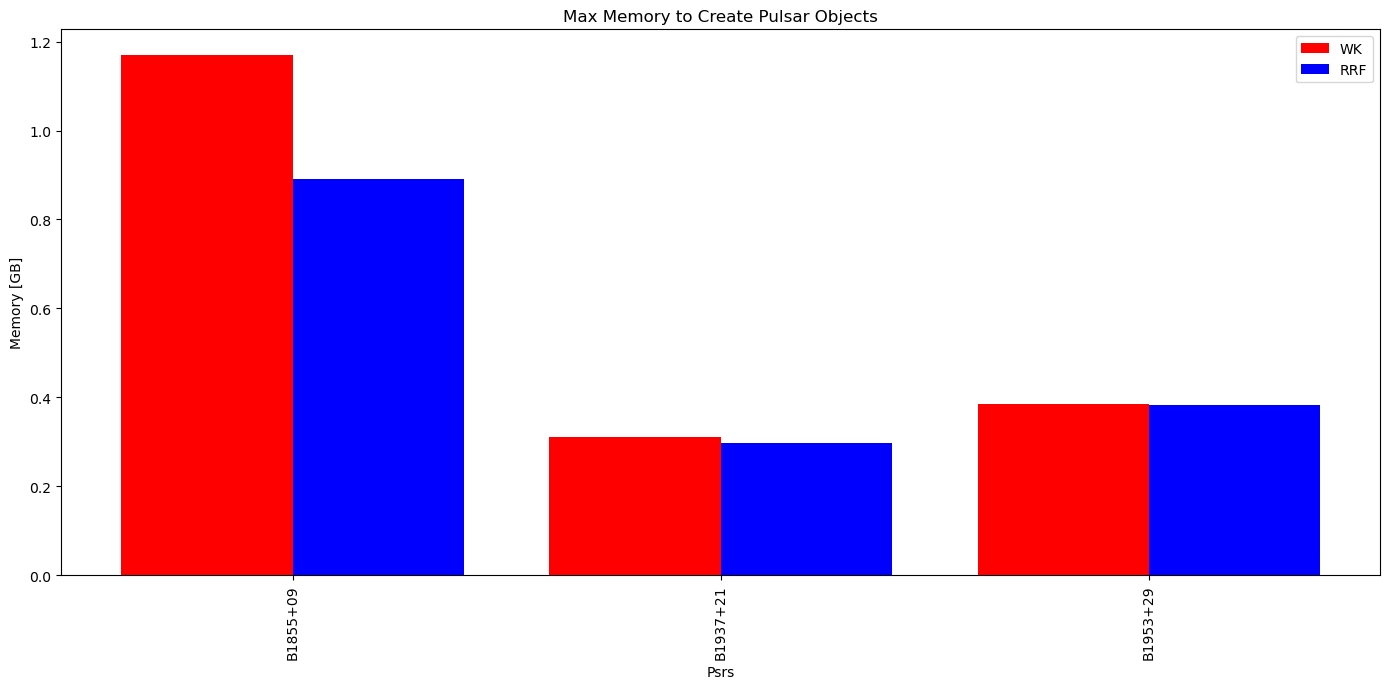

In [24]:
with open(profile_path + '/psrs_mem.txt', 'r') as file:
    OGS_psrs = {}
    RRFS_psrs = {}
    for line in file:
        parse_line = line.split()
        if parse_line[0] == 'WK':
            OGS_psrs.update({parse_line[1]: (float(parse_line[2]))})

        elif parse_line[0] == 'RRF':
            RRFS_psrs.update({parse_line[1]: (float(parse_line[2]))})

    all_names = OGS_psrs.keys()
    ogs_plot_values_psrs_mem = [OGS_psrs[name] if name in OGS_psrs else 0 for name in all_names]
    rrfs_plot_values_psrs_mem = [RRFS_psrs[name] if name in RRFS_psrs else 0 for name in all_names]

    x = range(len(all_names))
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    plt.bar(x, ogs_plot_values_psrs_mem, width=bar_width, label='WK', color='red', align='center')
    # Plot RRFS values (shifted to the right by bar_width)
    plt.bar([i + bar_width for i in x], rrfs_plot_values_psrs_mem, width=bar_width, label='RRF', color='blue', align='center')
    # Add names to the x-axis
    plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)
    plt.xlabel('Psrs')
    plt.ylabel('Memory [GB]')
    plt.title('Max Memory to Create Pulsar Objects')
    plt.legend(loc='upper right')
    # Show plot
    plt.tight_layout()
    plt.savefig(profile_path+'/mem_bar_psrs.svg') 
    plt.show()


Lets plot the time it takes to generate each `sensitivity.spectrum` object as a bar chart

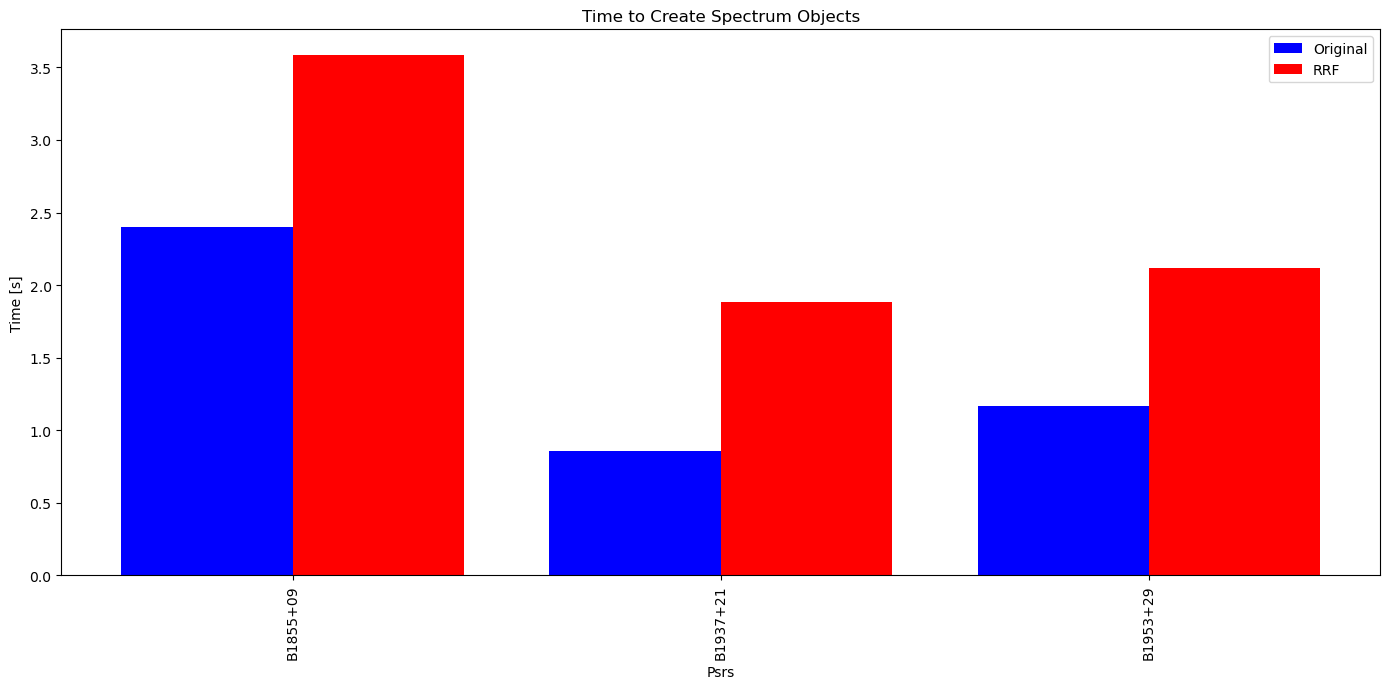

In [25]:
with open(profile_path + '/spec_increm.txt', 'r') as file:
    OGS_specs = {}
    RRFS_specs = {}
    for line in file:
        parse_line = line.split()
        if parse_line[0] == 'WK':
            OGS_specs.update({parse_line[1]: (float(parse_line[3])-float(parse_line[2]))})

        elif parse_line[0] == 'RRF':
            RRFS_specs.update({parse_line[1]: (float(parse_line[3])-float(parse_line[2]))})

    all_names = OGS_specs.keys()
    ogs_plot_values_specs = [OGS_specs[name] if name in OGS_specs else 0 for name in all_names]
    rrfs_plot_values_specs = [RRFS_specs[name] if name in RRFS_specs else 0 for name in all_names]

    x = range(len(all_names))
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    plt.bar(x, ogs_plot_values_specs, width=bar_width, label='Original', color='blue', align='center')
    plt.bar([i + bar_width for i in x], rrfs_plot_values_specs, width=bar_width, label='RRF', color='red', align='center')
    plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)

    plt.xlabel('Psrs')
    plt.ylabel('Time [s]')
    plt.title('Time to Create Spectrum Objects')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(profile_path+'/time_bar_specs.png') 
    plt.show()
    plt.close()

    with open(profile_path+'/spectra_total_time.txt', 'w') as file:
        file.write(f'Total WK Spec: {sum(ogs_plot_values_specs)}\n')
        file.write(f'Total RRF Spec: {sum(rrfs_plot_values_specs)}\n')

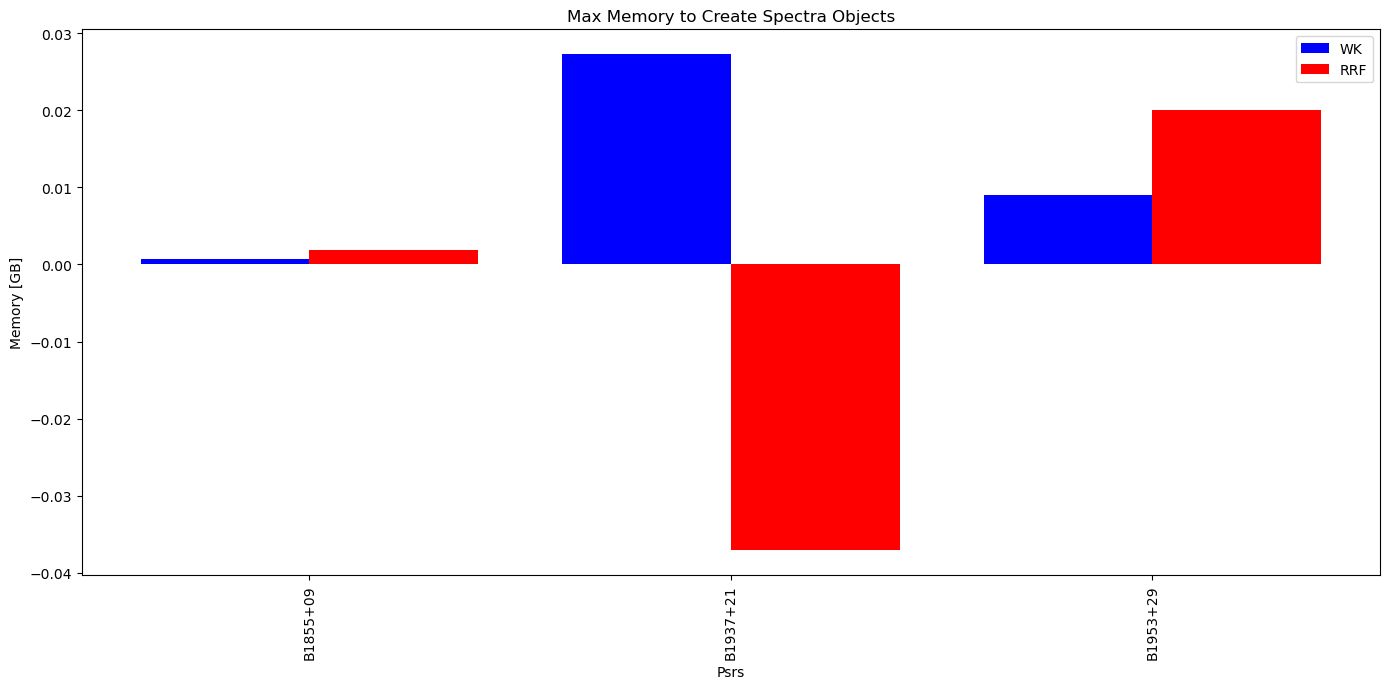

In [26]:
with open(profile_path + '/specs_mem.txt', 'r') as file:
    OGS_psrs = {}
    RRFS_psrs = {}
    for line in file:
        parse_line = line.split()
        if parse_line[0] == 'WK':
            OGS_psrs.update({parse_line[1]: (float(parse_line[2]))})

        elif parse_line[0] == 'RRF':
            RRFS_psrs.update({parse_line[1]: (float(parse_line[2]))})

    all_names = OGS_psrs.keys()
    ogs_plot_values_specs_mem = [OGS_psrs[name] if name in OGS_psrs else 0 for name in all_names]
    rrfs_plot_values_specs_mem = [RRFS_psrs[name] if name in RRFS_psrs else 0 for name in all_names]

    x = range(len(all_names))
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    plt.bar(x, ogs_plot_values_specs_mem, width=bar_width, label='WK', color='blue', align='center')
    # Plot RRFS values (shifted to the right by bar_width)
    plt.bar([i + bar_width for i in x], rrfs_plot_values_specs_mem, width=bar_width, label='RRF', color='red', align='center')
    # Add names to the x-axis
    plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)
    plt.xlabel('Psrs')
    plt.ylabel('Memory [GB]')
    plt.title('Max Memory to Create Spectra Objects')
    plt.legend(loc='upper right')
    # Show plot
    plt.tight_layout()
    plt.savefig(profile_path+'/mem_bar_specs.svg') 
    plt.show()


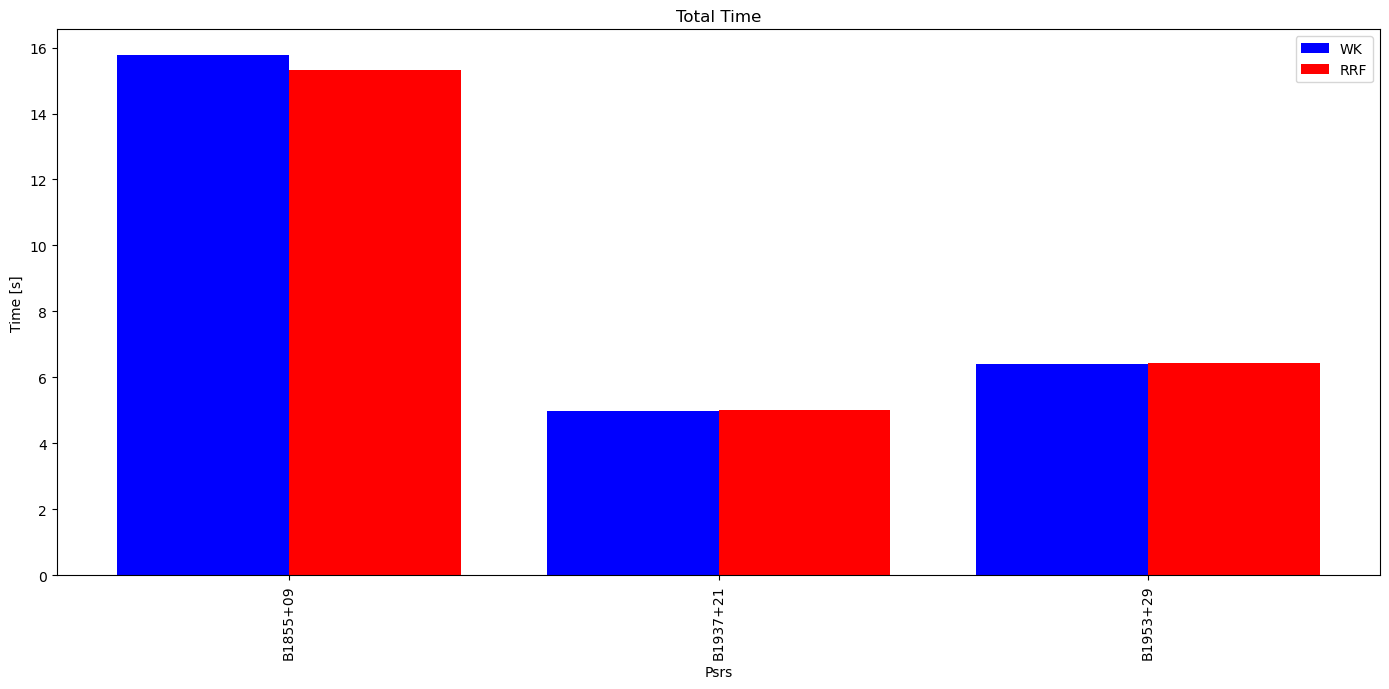

In [27]:
og_psrs_tm = np.array(ogs_plot_values_psrs)
rrf_psrs_tm = np.array(rrfs_plot_values_psrs)

og_specs_tm = np.array(ogs_plot_values_specs)
rrf_specs_tm = np.array(rrfs_plot_values_specs)

total_og_tm = og_psrs_tm + og_specs_tm
total_rrf_tm = rrf_psrs_tm + rrf_specs_tm

total_total_WK_time = np.sum(total_og_tm)
total_total_RRF_time = np.sum(total_rrf_tm)

x = range(len(all_names))

plt.figure(figsize=(14, 7))
bar_width = 0.4
plt.bar(x, total_og_tm, width=bar_width, label='WK', color='blue', align='center')
plt.bar([i + bar_width for i in x], total_rrf_tm, width=bar_width, label='RRF', color='red', align='center')

# Add names to the x-axis
plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)

plt.xlabel('Psrs')
plt.ylabel('Time [s]')
plt.title('Total Time')
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig(profile_path+'/time_bar_total.svg') 
plt.show()

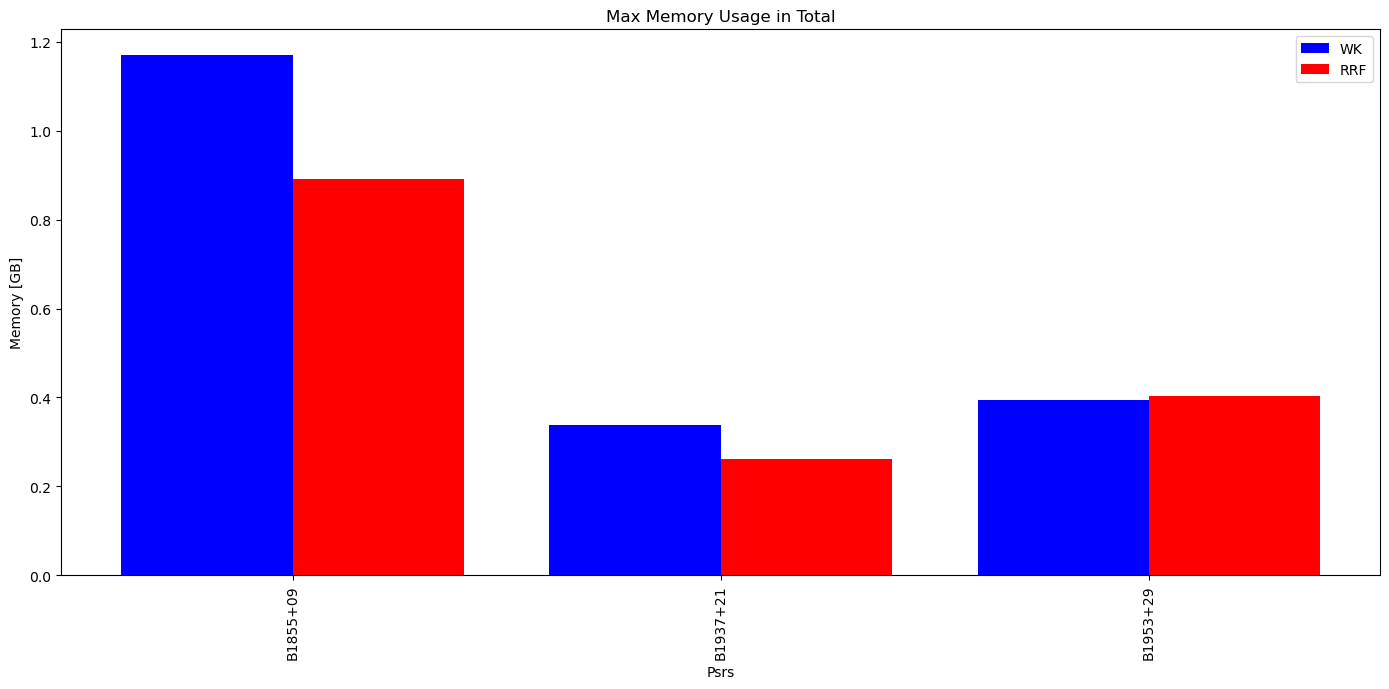

In [28]:
og_psrs_mem = np.array(ogs_plot_values_psrs_mem)
rrf_psrs_mem = np.array(rrfs_plot_values_psrs_mem)

og_specs_mem = np.array(ogs_plot_values_specs_mem)
rrf_specs_mem = np.array(rrfs_plot_values_specs_mem)

total_og_mem = og_psrs_mem + og_specs_mem
total_rrf_mem = rrf_psrs_mem + rrf_specs_mem
x = range(len(all_names))

plt.figure(figsize=(14, 7))
bar_width = 0.4
plt.bar(x, total_og_mem, width=bar_width, label='WK', color='blue', align='center')
plt.bar([i + bar_width for i in x], total_rrf_mem, width=bar_width, label='RRF', color='red', align='center')

# Add names to the x-axis
plt.xticks([i + bar_width / 2 for i in x], all_names, rotation=90)

plt.xlabel('Psrs')
plt.ylabel('Memory [GB]')
plt.title('Max Memory Usage in Total')
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig(profile_path+'/mem_bar_total.svg') 
plt.show()

In [29]:
data_path = os.path.expanduser(f'~/psr_data_15_yr')
hsen_dir = os.path.expanduser(f'{data_path}/hsen_psrs.hdf5')

pars, tims, noise, rn_psrs, edir, ephem = yr_15_data()
edir = data_path + edir

names_list = []
toas = []
Tspans = []
with h5py.File(edir, 'r') as f:
    #reading Tspan and creation of frequencies to observe
    Tspan = f['Tspan'][:][0]
    
    #reading names encoded as bytes, and re-converting them to strings, and deleting byte names
    names = f['names'][:]
    for i in range(len(names)):
        names_list.append(names[i].decode('utf-8'))
    del names

    #Original Method for creation of hasasia pulsars, and saving them to hdf5 file
    hsen_dir = os.path.expanduser(f'{data_path}/hsen_psrs.hdf5')
    with h5py.File(hsen_dir,'r') as hsenf:
        for name in names_list:
            psr = hsenf[name]
            toas_I = psr['toas'][:]
            tspan_I = max(toas_I)-min(toas_I)
            toas.append(len(toas_I))
            Tspans.append(tspan_I)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


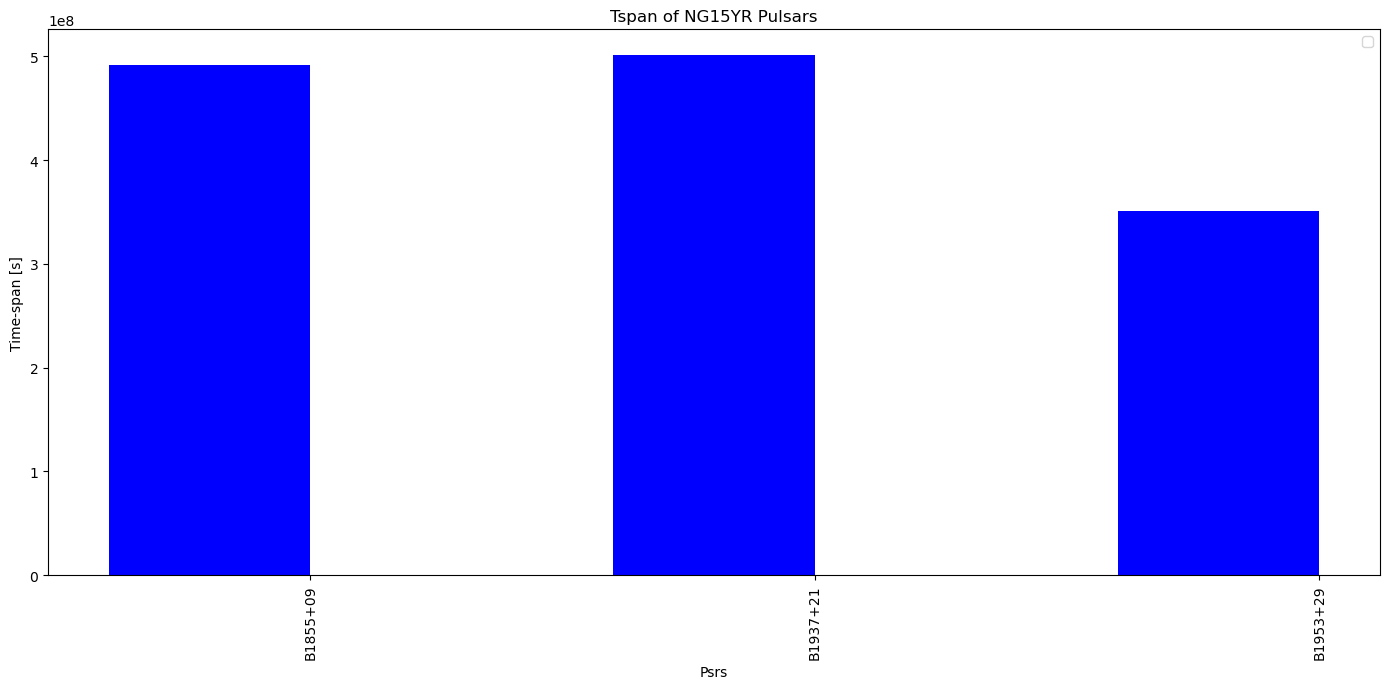

In [30]:
x = range(len(names_list))

plt.figure(figsize=(14, 7))
bar_width = 0.4
plt.bar(x, Tspans, width=bar_width, color='blue', align='center')


# Add names to the x-axis
plt.xticks([i + bar_width / 2 for i in x], names_list, rotation=90)

plt.xlabel('Psrs')
plt.ylabel('Time-span [s]')
plt.title('Tspan of NG15YR Pulsars')
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig(profile_path+'/Tspan_total.svg') 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


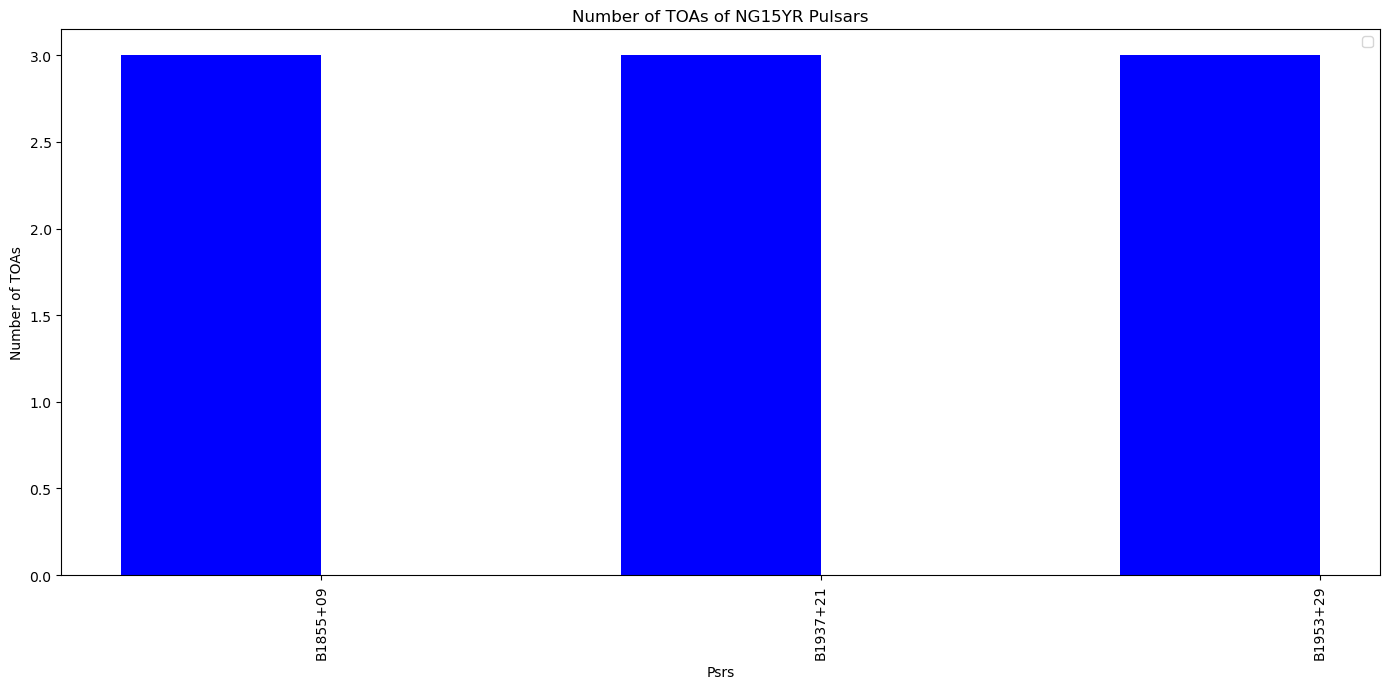

In [31]:
x = range(len(names_list))

plt.figure(figsize=(14, 7))
bar_width = 0.4
plt.bar(x, len(toas), width=bar_width, color='blue', align='center')


# Add names to the x-axis
plt.xticks([i + bar_width / 2 for i in x], names_list, rotation=90)

plt.xlabel('Psrs')
plt.ylabel('Number of TOAs')
plt.title('Number of TOAs of NG15YR Pulsars')
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig(profile_path+'/toas_total.svg') 
plt.show()

Lets now compare the total time it took to create `sensitivity.pulsar` objects, and `sensitivity.spectrum` objects using the WK-formalism, and lets compare it to the first run to create `sensitivity.pulsar` object and `sensitivity.spectrum` objects using the RRF. Lastly, we will compare the average runtime of the subsequent `sensitivity.spectrum` class creation using RRF, to show the speedup. With the WK-formalism, when you use a new powerlaw paramter, you must recrease `sensitivity.pular` object and new `sensitivity.spectrum` class, while for the RRF formalism, you only need to recreate `sensitivity.spectrum` object.

In [32]:
RRF_spectra_pwlw_var = []
with open(os.path.expanduser('~/profile_data_sens_var_15_yr/specs_RRF_mem.txt')) as file:
    for line in file:
        line_filter = line.strip('\n')
        RRF_spectra_pwlw_var.append(float(line_filter))

avg_spectra_pwlw_var = sum(RRF_spectra_pwlw_var)/len(RRF_spectra_pwlw_var)
print(avg_spectra_pwlw_var)

557.4750923871994


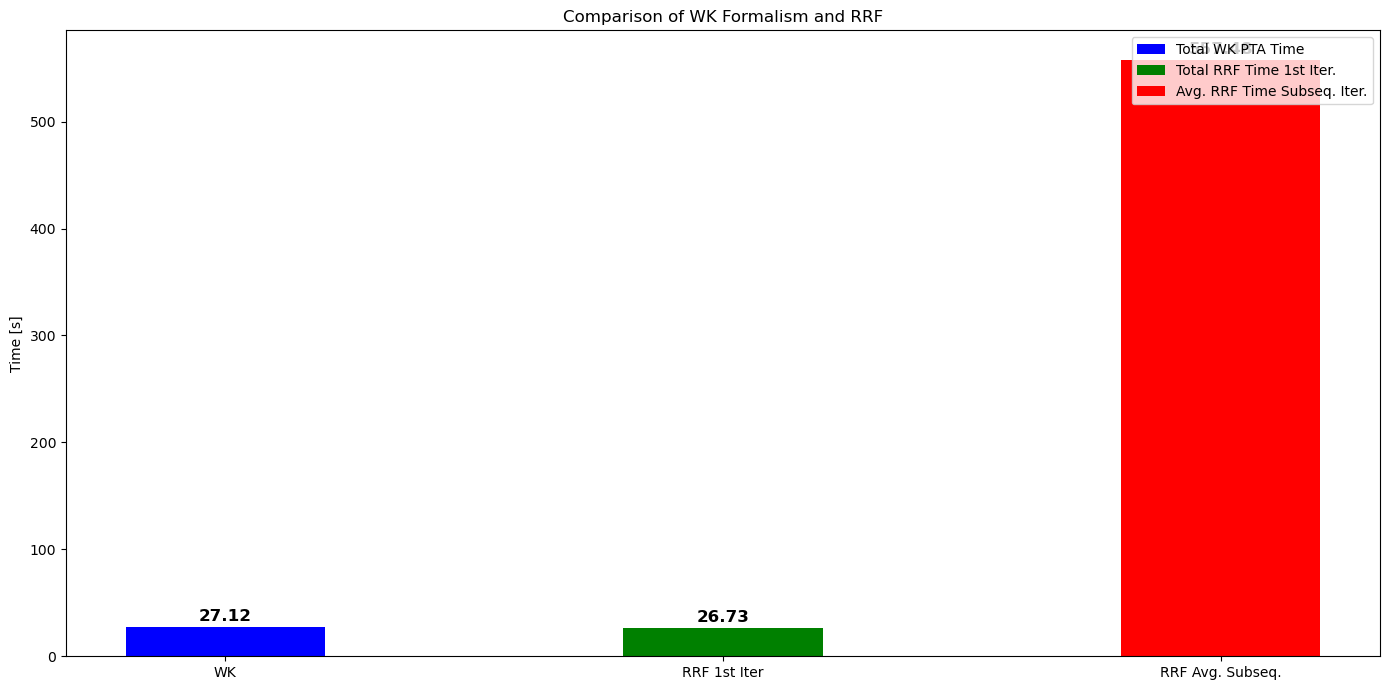

In [33]:
comp_values = (total_total_WK_time, total_total_RRF_time, avg_spectra_pwlw_var)
labels = ('Total WK PTA Time', 'Total RRF Time 1st Iter.', 'Avg. RRF Time Subseq. Iter.')
colors = ['blue', 'green', 'red']  # Define different colors for each bar

x = ['WK', 'RRF 1st Iter', 'RRF Avg. Subseq.']

plt.figure(figsize=(14, 7))
bar_width = 0.4
bars = plt.bar(x, comp_values, width=bar_width, color=colors, align='center')



# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(comp_values), 
             f'{height:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.ylabel('Time [s]')
plt.title('Comparison of WK Formalism and RRF')

# Manually create legend
plt.legend(bars, labels, loc='upper right')

# Show plot
plt.tight_layout()
plt.savefig(profile_path+'/complete_RRF_WK_comp.svg') 
plt.show()

